<a href="https://colab.research.google.com/github/VuyiswaK/LLMs_AIMs/blob/main/Part_1_intro_to_tokenization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# https://tinyurl.com/yw66n5fk

# Understanding Tokenization in LLMs with JAX

In this notebook, we'll explore the tokenization process for Large Language Models (LLMs) using JAX. Tokenization is the process of converting raw text into a format that can be processed by neural networks. This is a crucial preprocessing step for training and using LLMs.

# Introduction to Tokenization

LLMs cannot process raw text directly because text is categorical data, incompatible with the mathematical operations used in neural networks. We need to convert text into continuous-valued vectors, which is where tokenization and embeddings come in.

Let's start by importing the necessary libraries:

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
import re
import numpy as np
from typing import Dict, List, Tuple, Optional
import urllib.request

## Getting a Sample Text

Let's download a small sample text for our tokenization experiments:

In [ ]:
def download_sample_text(url, file_path):
    """Download a text file from the given URL."""

    return file_path

# Download a sample text (assuming the Verdict text is available)
url = ("https://raw.githubusercontent.com/rasbt/"
       "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
       "the-verdict.txt")
file_path = "the-verdict.txt"

urllib.request.urlretrieve(url, file_path)
print(f"Successfully downloaded to {file_path}")

Successfully downloaded to the-verdict.txt


In [ ]:
def read_text_file(file_path):
    """Read text from a file."""
    with open(file_path, "r", encoding="utf-8") as f:
        raw_text = f.read()
    return raw_text

# Read the text file
raw_text = read_text_file(file_path)
print(f"Total number of characters: {len(raw_text)}")
print(f"First 100 characters:\n{raw_text[:100]}")

Total number of characters: 20479
First 100 characters:
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


## Simple Tokenization

In the following section, we are going to implement a simple text tokenization function. Tokenization is the process of breaking text into smaller units (tokens) for natural language processing tasks. Our implementation will use regular expressions to split text at punctuation marks, spaces, and dashes, creating a list of meaningful tokens.

### 1. Splitting the text

In the first step, we will take a text string as input and returns a list of tokens. We'll use a regular expression pattern to identify splitting points and then clean the resulting list to remove empty entries.

In [ ]:
def tokenize_text(text):
    """Split text into tokens using regular expressions."""
    tokens = re.split(r'([,.:;?_!"()\'\']|--|\s)', text)
    tokens = [item.strip() for item in tokens if item.strip()]
    return tokens

# Tokenize a simple example
simple_text = "Hello, world. Is this-- a test?"
tokens = tokenize_text(simple_text)
print(f"Tokenized text: {tokens}")

Tokenized text: ['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [ ]:
# Tokenize our sample text
sample_tokens = tokenize_text(raw_text[:500])  # First 500 chars to keep output manageable
print(f"Number of tokens in sample: {len(sample_tokens)}")
print(f"First 30 tokens: {sample_tokens[:30]}")

Number of tokens in sample: 110
First 30 tokens: ['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


### 2. Building a Vocabulary

In this step, we are going to implement a vocabulary builder function that converts our tokenized text into a format suitable for machine learning models. This process assigns a unique integer ID to each distinct token in our dataset, creating mappings that allow us to convert back and forth between tokens and their IDs.

In [ ]:
def build_vocabulary(tokens):
    """Create a vocabulary mapping tokens to integer IDs."""
    unique_tokens = sorted(set(tokens))
    token_to_id = {token: idx for idx, token in enumerate(unique_tokens)}
    id_to_token = {idx: token for token, idx in token_to_id.items()}
    return token_to_id, id_to_token, len(unique_tokens)

# Tokenize the entire text
all_tokens = tokenize_text(raw_text)

# Build vocabulary
token_to_id, id_to_token, vocab_size = build_vocabulary(all_tokens)

print(f"Vocabulary size: {vocab_size}")
print("\nSample of the vocabulary:")
for i, (token, idx) in enumerate(list(token_to_id.items())[:10]):
    print(f"'{token}' -> {idx}")

Vocabulary size: 1130

Sample of the vocabulary:
'!' -> 0
'"' -> 1
''' -> 2
'(' -> 3
')' -> 4
',' -> 5
'--' -> 6
'.' -> 7
':' -> 8
';' -> 9


### 3. Add special tokens to our vocabulary

We then enhance our vocabulary by adding special tokens that serve specific purposes in language models: an end-of-text marker and an unknown token placeholder. These tokens help the model understand text boundaries and handle words it hasn't seen before.

In [ ]:
def tokens_to_ids(tokens, token_to_id, unk_token="<|unk|>"):
    """Convert tokens to token IDs, using unk_token for unknown tokens."""
    return [token_to_id.get(token, token_to_id[unk_token]) for token in tokens]

def ids_to_tokens(ids, id_to_token):
    """Convert token IDs back to tokens."""
    return [id_to_token[idx] for idx in ids]

# Add special tokens to our vocabulary
special_tokens = ["<|endoftext|>", "<|unk|>"]
for token in special_tokens:
    if token not in token_to_id:
        token_to_id[token] = len(token_to_id)
        id_to_token[len(id_to_token)] = token

# Convert sample tokens to IDs
sample_token_ids = tokens_to_ids(sample_tokens, token_to_id)
print(f"Token IDs: {sample_token_ids[:20]}")

# Convert back to tokens
reconstructed_tokens = ids_to_tokens(sample_token_ids[:20], id_to_token)
print(f"Reconstructed tokens: {reconstructed_tokens}")

Token IDs: [53, 44, 149, 1003, 57, 38, 818, 115, 256, 486, 6, 1002, 115, 500, 435, 392, 6, 908, 585, 1077]
Reconstructed tokens: ['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was']


In [ ]:
token_to_id

{'!': 0,
 '"': 1,
 "'": 2,
 '(': 3,
 ')': 4,
 ',': 5,
 '--': 6,
 '.': 7,
 ':': 8,
 ';': 9,
 '?': 10,
 'A': 11,
 'Ah': 12,
 'Among': 13,
 'And': 14,
 'Are': 15,
 'Arrt': 16,
 'As': 17,
 'At': 18,
 'Be': 19,
 'Begin': 20,
 'Burlington': 21,
 'But': 22,
 'By': 23,
 'Carlo': 24,
 'Chicago': 25,
 'Claude': 26,
 'Come': 27,
 'Croft': 28,
 'Destroyed': 29,
 'Devonshire': 30,
 'Don': 31,
 'Dubarry': 32,
 'Emperors': 33,
 'Florence': 34,
 'For': 35,
 'Gallery': 36,
 'Gideon': 37,
 'Gisburn': 38,
 'Gisburns': 39,
 'Grafton': 40,
 'Greek': 41,
 'Grindle': 42,
 'Grindles': 43,
 'HAD': 44,
 'Had': 45,
 'Hang': 46,
 'Has': 47,
 'He': 48,
 'Her': 49,
 'Hermia': 50,
 'His': 51,
 'How': 52,
 'I': 53,
 'If': 54,
 'In': 55,
 'It': 56,
 'Jack': 57,
 'Jove': 58,
 'Just': 59,
 'Lord': 60,
 'Made': 61,
 'Miss': 62,
 'Money': 63,
 'Monte': 64,
 'Moon-dancers': 65,
 'Mr': 66,
 'Mrs': 67,
 'My': 68,
 'Never': 69,
 'No': 70,
 'Now': 71,
 'Nutley': 72,
 'Of': 73,
 'Oh': 74,
 'On': 75,
 'Once': 76,
 'Only': 77,
 '

### 4. Complete Tokenizer Implementation

Finally, we are going to wrap all these functions in one interface

In [ ]:
class SimpleTokenizer:
    def __init__(self, vocab: Optional[Dict[str, int]] = None):
        """Initialize tokenizer with a vocabulary or create one."""
        self.token_to_id = vocab or {}
        self.id_to_token = {i: s for s, i in self.token_to_id.items()}

        # Add special tokens if they don't exist
        self._add_special_tokens(["<|endoftext|>", "<|unk|>"])

    def _add_special_tokens(self, special_tokens):
        """Add special tokens to the vocabulary."""
        for token in special_tokens:
            if token not in self.token_to_id:
                self.token_to_id[token] = len(self.token_to_id)
                self.id_to_token[len(self.id_to_token)] = token

    def build_vocab_from_text(self, text):
        """Build vocabulary from text."""
        tokens = tokenize_text(text)
        unique_tokens = sorted(set(tokens))
        self.token_to_id = {token: idx for idx, token in enumerate(unique_tokens)}
        self._add_special_tokens(["<|endoftext|>", "<|unk|>"])
        self.id_to_token = {i: s for s, i in self.token_to_id.items()}
        return len(self.token_to_id)

    def encode(self, text):
        """Encode text to token IDs."""
        tokens = tokenize_text(text)
        tokens = [
            token if token in self.token_to_id else "<|unk|>"
            for token in tokens
        ]
        return [self.token_to_id[s] for s in tokens]

    def decode(self, ids):
        """Decode token IDs back to text."""
        text = " ".join([self.id_to_token[i] for i in ids])
        # Clean up spaces before punctuation
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

    @property
    def vocab_size(self):
        """Get the vocabulary size."""
        return len(self.token_to_id)

In [ ]:
# Create and test our tokenizer
tokenizer = SimpleTokenizer()
vocab_size = tokenizer.build_vocab_from_text(raw_text)
print(f"Vocabulary size: {vocab_size}")

# Test encoding and decoding
test_text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace."
encoded = tokenizer.encode(test_text)
print(f"Encoded: {encoded}")
decoded = tokenizer.decode(encoded)
print(f"Decoded: {decoded}")

Vocabulary size: 1132
Encoded: [1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]
Decoded: <|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


## Byte Pair Encoding (BPE) with External Library

JAX doesn't have a built-in BPE tokenizer, but we can use external libraries like `tiktoken`. `tiktoken` is a fast BPE tokeniser for use with OpenAI's models.

In [ ]:
! pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.8 MB/s eta 0:00:00


Here, we will see the BPE encoding for a sample text

In [ ]:
import tiktoken

# Get the BPE tokenizer used by GPT models."""
bpe_tokenizer = tiktoken.get_encoding("gpt2")

# Test encoding and decoding
bpe_test = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
bpe_encoded = bpe_tokenizer.encode(bpe_test, allowed_special={"<|endoftext|>"})
bpe_decoded = bpe_tokenizer.decode(bpe_encoded)

print(f"BPE encoded: {bpe_encoded}")
print(f"BPE decoded: {bpe_decoded}")

BPE encoded: [15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]
BPE decoded: Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


Let's see how BPE handles unknown words

In [ ]:
# Show how BPE handles unknown words
unknown_word = "Akwirw ier"
unknown_encoded = bpe_tokenizer.encode(unknown_word)
print(f"\nUnknown word: '{unknown_word}'")
print(f"BPE encoded: {unknown_encoded}")

# Show each token
for token_id in unknown_encoded:
    print(f"Token ID {token_id}: '{bpe_tokenizer.decode([token_id])}'")


Unknown word: 'Akwirw ier'
BPE encoded: [33901, 86, 343, 86, 220, 959]
Token ID 33901: 'Ak'
Token ID 86: 'w'
Token ID 343: 'ir'
Token ID 86: 'w'
Token ID 220: ' '
Token ID 959: 'ier'


## Data Sampling with Sliding Window



In this section, we are going to implement a function that prepares our tokenized text for training a language model. The function generates input-target pairs using a sliding window approach, which is fundamental for training models to predict the next token in a sequence.

In [ ]:
def create_input_target_pairs(token_ids, context_size, stride=1):
    """Create input-target pairs using a sliding window approach."""
    inputs = []
    targets = []

    for i in range(0, len(token_ids) - context_size, stride):
      input_chunk = token_ids[i:i + context_size]
      target_chunk = token_ids[i + 1:i + context_size + 1] #
      inputs.append(input_chunk)
      targets.append(target_chunk)

    return jnp.array(inputs), jnp.array(targets)

In [ ]:
# Encode the entire text
full_encoded = bpe_tokenizer.encode(raw_text)
# Create input-target pairs with a small context size for demonstration
context_size = 4
inputs, targets = create_input_target_pairs(full_encoded[:100], context_size, stride=2)

print(f"Inputs shape: {inputs.shape}")
print(f"Targets shape: {targets.shape}")

# Show some examples
for i in range(3):  # Just show first 3 examples
    input_text = bpe_tokenizer.decode(inputs[i])
    target_text = bpe_tokenizer.decode(targets[i])
    print(f"\nInput {i+1}: {input_text}")
    print(f"Target {i+1}: {target_text}")

    # Show what the model is actually trying to predict
    for j in range(context_size):
        if j < len(inputs[i]):
            context = bpe_tokenizer.decode(inputs[i][:j+1])
            next_token = bpe_tokenizer.decode([targets[i][j]])
            print(f"  Context: '{context}' --> Next token: '{next_token}'")

Inputs shape: (48, 4)
Targets shape: (48, 4)

Input 1: I HAD always
Target 1:  HAD always thought
  Context: 'I' --> Next token: ' H'
  Context: 'I H' --> Next token: 'AD'
  Context: 'I HAD' --> Next token: ' always'
  Context: 'I HAD always' --> Next token: ' thought'

Input 2: AD always thought Jack
Target 2:  always thought Jack G
  Context: 'AD' --> Next token: ' always'
  Context: 'AD always' --> Next token: ' thought'
  Context: 'AD always thought' --> Next token: ' Jack'
  Context: 'AD always thought Jack' --> Next token: ' G'

Input 3:  thought Jack Gis
Target 3:  Jack Gisburn
  Context: ' thought' --> Next token: ' Jack'
  Context: ' thought Jack' --> Next token: ' G'
  Context: ' thought Jack G' --> Next token: 'is'
  Context: ' thought Jack Gis' --> Next token: 'burn'


## Token Embeddings with JAX

In this section, we are going to implement a word embedding layer for our language model. Word embeddings transform discrete token IDs into continuous vector spaces, capturing semantic relationships between words and making them suitable for neural network processing.

Our function creates a randomly initialized embedding matrix where each row represents a token from our vocabulary. The values are drawn from a normal distribution and scaled by the square root of the embedding dimension to help with training stability.

In [ ]:
def create_embedding_layer(vocab_size, embedding_dim, key):
    """Create an embedding matrix with JAX."""
    # Initialize with a normal distribution scaled by the square root of embedding_dim
    embedding_matrix = jax.random.normal(key, (vocab_size, embedding_dim)) / jnp.sqrt(embedding_dim)

    def embed(token_ids):
        """Embed token IDs."""
        return jnp.take(embedding_matrix, token_ids, axis=0)

    return embed, embedding_matrix

# Initialize embedding layer
vocab_size = tokenizer.vocab_size
embedding_dim = 256
key = jax.random.PRNGKey(0)

token_embedding_fn, token_embedding_matrix = create_embedding_layer(
    vocab_size, embedding_dim, key
)

In [ ]:
# Test with a single token
single_token = jnp.array([42])
single_embedding = token_embedding_fn(single_token)
print(f"Single token embedding shape: {single_embedding.shape}")

# Test with a batch of tokens
batch_tokens = inputs[:2]  # Take first 2 examples
batch_embeddings = token_embedding_fn(batch_tokens)
print(f"Batch embeddings shape: {batch_embeddings.shape}")

# Let's look at a small sample of the actual embedding values
print(f"\nSample embedding values for token ID 42:")
print(single_embedding[0, :5])  # First 5 dimensions

Single token embedding shape: (1, 256)
Batch embeddings shape: (2, 4, 256)

Sample embedding values for token ID 42:
[ 0.110055   -0.08880654  0.01889226 -0.00981834 -0.0037331 ]


## Positional Embeddings

In this section, we are going to implement positional embeddings that enable our language model to understand token order in sequences. This function creates a randomly initialized matrix where each row represents position information for tokens in a sequence.

In [ ]:
def create_positional_embeddings(max_length, embedding_dim, key):
    """Create positional embeddings with JAX."""
    pos_embedding_matrix = jax.random.normal(key, (max_length, embedding_dim)) / jnp.sqrt(embedding_dim)

    def get_positional_embeddings(length):
        """Get positional embeddings for a specific length."""
        return pos_embedding_matrix[:length]

    return get_positional_embeddings, pos_embedding_matrix

# Initialize positional embeddings
max_length = 1024  # Maximum sequence length
pos_key = jax.random.PRNGKey(1)
pos_embedding_fn, pos_embedding_matrix = create_positional_embeddings(
    max_length, embedding_dim, pos_key
)

In [ ]:
# Get positional embeddings for our context size
pos_embeddings = pos_embedding_fn(context_size)
print(f"Positional embeddings shape: {pos_embeddings.shape}")

# Add positional embeddings to token embeddings for the first batch example
input_with_pos = batch_embeddings[0] + pos_embeddings
print(f"Input with positional embeddings shape: {input_with_pos.shape}")

# Let's see how the positional embeddings affect the actual values
print(f"\nFirst 5 values for token 0 without positional embedding:")
print(batch_embeddings[0, 0, :5])
print(f"\nFirst 5 values for position 0:")
print(pos_embeddings[0, :5])
print(f"\nFirst 5 values for token 0 with positional embedding:")
print(input_with_pos[0, :5])

Positional embeddings shape: (4, 256)
Input with positional embeddings shape: (4, 256)

First 5 values for token 0 without positional embedding:
[ 0.01715419  0.07272937 -0.13880892 -0.01006357 -0.03753179]

First 5 values for position 0:
[-0.00965232  0.0052942  -0.00849878 -0.00968977  0.07916671]

First 5 values for token 0 with positional embedding:
[ 0.00750187  0.07802358 -0.1473077  -0.01975334  0.04163492]


## Complete Pipeline: From Text to Model Input

Let's put it all together to demonstrate the complete pipeline:

In [ ]:
def text_to_model_input(text, tokenizer, token_embed_fn, pos_embed_fn, context_size):
    """Convert text to model input with embeddings."""
    # Tokenize and encode
    token_ids = tokenizer.encode(text)

    # Truncate if necessary
    if len(token_ids) > context_size:
        token_ids = token_ids[:context_size]

    # Pad if necessary
    if len(token_ids) < context_size:
        token_ids = token_ids + [tokenizer.token_to_id["<|endoftext|>"]] * (context_size - len(token_ids))

    # Convert to JAX array
    token_ids_array = jnp.array(token_ids)

    # Get token embeddings
    token_embeddings = token_embed_fn(token_ids_array)

    # Get positional embeddings
    pos_embeddings = pos_embed_fn(context_size)

    # Combine embeddings
    input_embeddings = token_embeddings + pos_embeddings

    return input_embeddings, token_ids

In [ ]:
# Test with a new text
test_input = "The quick brown fox jumps over the lazy dog."
model_input, token_ids = text_to_model_input(
    test_input, tokenizer, token_embedding_fn, pos_embedding_fn, context_size=8
)

print(f"Input text: {test_input}")
print(f"Token IDs: {token_ids}")
print(f"Model input shape: {model_input.shape}")

# Show what each position in the input represents
tokens = [tokenizer.id_to_token[int(id)] for id in token_ids]
print("\nPositional breakdown:")
for i, token in enumerate(tokens):
    print(f"Position {i}: '{token}' + Positional Embedding {i}")

Input text: The quick brown fox jumps over the lazy dog.
Token IDs: [93, 1131, 235, 1131, 1131, 741, 988, 1131]
Model input shape: (8, 256)

Positional breakdown:
Position 0: 'The' + Positional Embedding 0
Position 1: '<|unk|>' + Positional Embedding 1
Position 2: 'brown' + Positional Embedding 2
Position 3: '<|unk|>' + Positional Embedding 3
Position 4: '<|unk|>' + Positional Embedding 4
Position 5: 'over' + Positional Embedding 5
Position 6: 'the' + Positional Embedding 6
Position 7: '<|unk|>' + Positional Embedding 7


## Visualizing Token Embeddings
Let's try to visualize the token embeddings to get a sense of how similar tokens might cluster together:

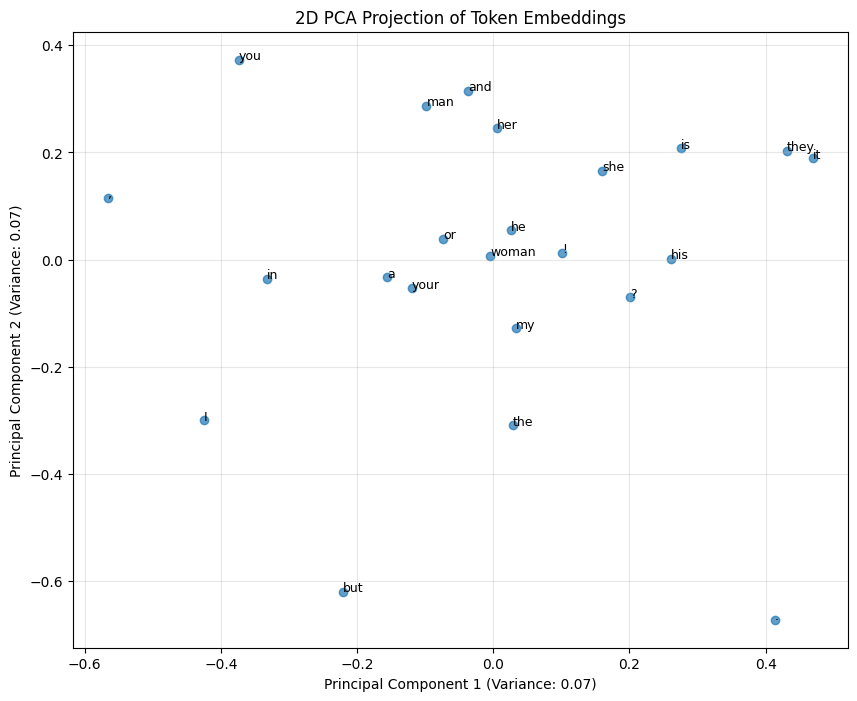

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Select a subset of common tokens
common_tokens = [
    "the", "a", "is", "in", "and", "he", "she", "it", "but", "or",
    "man", "woman", "boy", "girl", "person",
    "I", "you", "we", "they", "my", "your", "his", "her",
    ".", ",", "!", "?"
]

# Filter to tokens that exist in our vocabulary
available_tokens = [t for t in common_tokens if t in tokenizer.token_to_id]

if len(available_tokens) > 5:  # Make sure we have enough tokens
    # Get token IDs
    token_ids = [tokenizer.token_to_id[t] for t in available_tokens]

    # Get the embeddings
    token_embeds = token_embedding_fn(jnp.array(token_ids))

    # Convert to numpy for sklearn
    embeds_np = np.array(token_embeds)

    # Reduce to 2 dimensions for visualization
    pca = PCA(n_components=2)
    embeds_2d = pca.fit_transform(embeds_np)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeds_2d[:, 0], embeds_2d[:, 1], alpha=0.7)

    # Add labels
    for i, token in enumerate(available_tokens):
        plt.annotate(token, (embeds_2d[i, 0], embeds_2d[i, 1]), fontsize=9)

    plt.title("2D PCA Projection of Token Embeddings")
    plt.xlabel(f"Principal Component 1 (Variance: {pca.explained_variance_ratio_[0]:.2f})")
    plt.ylabel(f"Principal Component 2 (Variance: {pca.explained_variance_ratio_[1]:.2f})")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("Not enough common tokens found in the vocabulary for visualization")



## Conclusion

In this notebook, we've:

1. Implemented a simple tokenizer from scratch
2. Built a vocabulary from text
3. Converted tokens to IDs and back
4. Created a sliding window data sampling approach
5. Implemented token and positional embeddings using JAX
6. Demonstrated the complete pipeline from text to model inputs
7. Introduced BPE tokenization

This tokenization process is the essential first step in preparing text data for training and using large language models. The token and positional embeddings we've created would then be fed into the transformer architecture that makes up the core of modern LLMs.

# Exercise
Implement UTF-8 Byte Level tokenizer using the same interface, you can use the following code as a starting code.

In [ ]:
txt = "Ståle"

token_to_id = {idx : list(idx.encode(encoding = "UTF-8"))[0] for idx in txt}
token_to_id

{'S': 83, 't': 116, 'å': 195, 'l': 108, 'e': 101}

In [ ]:
txt.encode(encoding = "UTF-8")

b'St\xc3\xa5le'

In [ ]:
[f.encode() for f in list(txt)]

[b'S', b't', b'\xc3\xa5', b'l', b'e']

In [ ]:
class ByteLevelTokenizer:
    def __init__(self):
        """Initialize the tokenizer."""
        self.token_to_id = {}
        self.id_to_token = {}

    def add_token_to_vocab(self, token):
      """Adds a token to the vocabulary if it's not already there."""
      for t in token:
        if t not in self.token_to_id:
            self.token_to_id[t] = list(t.encode(encoding = "UTF-8"))[0]
            self.id_to_token[list(t.encode(encoding = "UTF-8"))[0]] = t


    def build_vocab(self, text):
      """Builds the vocabulary from the provided text."""
      self.token_to_id = {idx : list(idx.encode(encoding = "UTF-8"))[0] for idx in text}
      self.id_to_token = {list(idx.encode(encoding = "UTF-8"))[0] : idx  for idx in text}
      print(self.id_to_token)
      return len(self.token_to_id)



    def encode(self, text):
        """Encodes text into a sequence of byte-level token IDs."""

        tokens = list(text)
        for token in tokens:
          if token not in self.token_to_id:
              self.add_token_to_vocab([token])

        return [self.token_to_id[s] for s in tokens]

    def decode(self, token_ids):
        """Decodes a sequence of byte-level token IDs back into text."""
        text = " ".join([self.id_to_token[i] for i in token_ids])
        # Clean up spaces before punctuation
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

# Example usage with build_vocab:
tokenizer = ByteLevelTokenizer()
training_text = "This is the text used to build the vocabulary."
tokenizer.build_vocab(training_text)

# Now you can encode and decode using the pre-built vocabulary
text = "This is a new sentence."
encoded = tokenizer.encode(text)
decoded = tokenizer.decode(encoded)

print(f"Original text: {text}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")

{84: 'T', 104: 'h', 105: 'i', 115: 's', 32: ' ', 116: 't', 101: 'e', 120: 'x', 117: 'u', 100: 'd', 111: 'o', 98: 'b', 108: 'l', 118: 'v', 99: 'c', 97: 'a', 114: 'r', 121: 'y', 46: '.'}
Original text: This is a new sentence.
Encoded: [84, 104, 105, 115, 32, 105, 115, 32, 97, 32, 110, 101, 119, 32, 115, 101, 110, 116, 101, 110, 99, 101, 46]
Decoded: T h i s   i s   a   n e w   s e n t e n c e.
